# Variational data generative model for intrusion detection

#### The objective of a Network Intrusion Detection System (NIDS) is to automate the detection of policy and security violations and malicious activities against a host in a network. Critical to any detection system is the ability to access balanced and diversified data to train the system. Intrusion data rarely have these characteristics, as the network traffic samples are strongly biased to the normal type of traffic, being difficult to access traffic associated to anomalous intrusion events. Therefore, it is important to be able to synthesize intrusion data with a structure similar to the original one.  In this way, we avoid investing significant resources in tasks such as obtaining additional intrusion data or manually simulating attacks. In this work we provide a method to generate synthetic data of similar probabilistic structure to real intrusion detection training data, having both continuous and categorical features and being strongly unbalanced to some of their associated classes. We generate the data conditioned to the class (label) to which the data should belong. That is, from a particular set of labels we generate training samples associated to that set of labels, mirroring the probabilistic structure of the original data that comes from those labels. We use a generative model based on Variational Autoencoder (VAE) concepts but using the intrusion class labels as input, instead of the original data itself. This modification provides an advantage, as we can readily generate new data using only the labels, without having to rely on training samples as canonical representatives for each label, what makes the generation process more reliable, less complex and much faster. We show that the generated data have similar probabilistic structure to the original data, and that the new synthesized data can be used to improve classification results from common machine learning classifiers.




# 1. Prepare dataset
#### Load NSL-KDD dataset to perform training of the model and latter to assess its performance

In [1]:
# set working directory
import os
os.chdir("W:/UVA/InvestigacionUVA/Informe proyecto 2017/Codigo_papers/vae")


####################################################
# Load variables from previous session
####################################################
import dill
#dill.load_session('tf_NSL_KDD_Load.pkl')
load_from_pkl = True
if load_from_pkl:
    dill.load_session('tf_NSL_KDD20_Load_withWs.pkl')
####################################################

In [2]:
import sklearn
sklearn.__version__

'0.18.1'

In [3]:
import lib
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
import pandas.core.algorithms as algos
from pandas import Series
from sklearn.preprocessing import OneHotEncoder



## 1.1 Create Training and Test datasets
#### Next we need to prepare the test and train data with one-hot encoding. We need to scale also the training data as NN is sensitive to data scaling

In [4]:
if not load_from_pkl:
    # create Y, matrix 
    YTrain = dataTrain['class']
    YTest = dataTest['class']


    # create X, matrix 
    XTest = dataTest.drop(['class','difficulty'], axis = 1)
    XTrain = dataTrain.drop(['class','difficulty'], axis = 1)
    lenXTrain = len(XTrain)
    lenXTest = len(XTest)

    # extract continous features
    XTrainContinous = dataTrain.drop(['class','difficulty','protocol_type', 'service','flag'], axis = 1)
    XTestContinous = dataTest.drop(['class','difficulty','protocol_type', 'service','flag'], axis = 1)

    # Eliminate columns which are mainly zeros
    t = XTrainContinous.apply(lambda x: sum(x != 0)) 
    minNumZeros = 100
    indexToErase = t[t<100].index
    XTrainContinous = XTrainContinous.drop(indexToErase, axis = 1)
    XTestContinous = XTestContinous.drop(indexToErase, axis = 1)

    # convert columns with continous data to categorical data, using a quantile over the values of each column.
    #XTrainContinousAsDis = XTrainContinous.apply(lambda x: pd.qcut(x, 20, labels=False))
    #XTestContinousAsDis = XTestContinous.apply(lambda x: pd.qcut(x, 20, labels=False))
    nBins = 40  # number of bins when doing the quantiles
    XTrainContinousAsDis = XTrainContinous.apply(lambda x: lib.helpFun2 (x, nBins)).astype(str)
    XTestContinousAsDis = XTestContinous.apply(lambda x: lib.helpFun2 (x, nBins)).astype(str)

    # extract discrete features
    XTrainDiscrete = dataTrain.loc[:,['protocol_type', 'service','flag']]
    XTestDiscrete = dataTest.loc[:,['protocol_type', 'service','flag']]

    # normalize the continous features

    # apply log(x+1) transform to features with great range
    tXTest = XTestContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
    'num_root', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']]
    tXTrain = XTrainContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
    'num_root', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']]

    XTestContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
                    'num_root', 'count', 'srv_count', 'dst_host_count', 
                    'dst_host_srv_count']] = tXTest.apply(lambda x: np.log(x+1), 0)
    XTrainContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
                     'num_root', 'count', 'srv_count', 'dst_host_count',
                     'dst_host_srv_count']] = tXTrain.apply(lambda x: np.log(x+1), 0)
    # and then apply an additional min-max or standard scaler to all the continous features
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    XTrainContinous = pd.DataFrame(scaler.fit_transform(XTrainContinous), columns=XTrainContinous.columns)
    XTestContinous = pd.DataFrame(scaler.fit_transform(XTestContinous), columns=XTestContinous.columns)


    # get back the full training data sets
    #XTrainAll =pd.concat([XTrainContinousAsDis,XTrainDiscrete], axis=1)
    #XTestAll =pd.concat([XTestContinousAsDis,XTestDiscrete], axis=1)
    XTrainAll =pd.concat([XTrainContinous,XTrainDiscrete], axis=1)
    XTestAll =pd.concat([XTestContinous,XTestDiscrete], axis=1)

    # one-hot encode the categorical features
    XAll = XTrainAll.append(XTestAll, ignore_index = True)
    #col_names = list(XAll.columns.values)
    col_names = ['protocol_type', 'service','flag']
    XAll, _, _= lib.one_hot_dataframe(XAll, col_names, replace=True)

    # extract XTrain and XTest
    XTrain = XAll.ix[:lenXTrain-1]
    XTest = XAll.ix[lenXTrain:]


    #convert to matrix
    XTrainM = XTrain.as_matrix()
    XTestM = XTest.as_matrix()

    # one hot encode Y and convert to matrix
    YTrainM = YTrain.as_matrix()
    YTestM = YTest.as_matrix()

    # for the VAE
    XTrainContinousM = XTrainContinous.as_matrix()
    XTestContinousM = XTestContinous.as_matrix()
    XAllDiscrete = XTrainDiscrete.append(XTestDiscrete, ignore_index = True)
    XAllDiscrete, _, _= lib.one_hot_dataframe(XAllDiscrete, col_names, replace=True)
    XAllDiscrete_flg = XAllDiscrete.ix[:,:11]
    XAllDiscrete_prot = XAllDiscrete.ix[:,11:14]
    XAllDiscrete_srv = XAllDiscrete.ix[:,14:]
    XTrainDiscreteM = XAllDiscrete.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteM = XAllDiscrete.ix[lenXTrain:].as_matrix()
    XTrainDiscreteflgM = XAllDiscrete_flg.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteflgM = XAllDiscrete_flg.ix[lenXTrain:].as_matrix()
    XTrainDiscreteprotM = XAllDiscrete_prot.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteprotM = XAllDiscrete_prot.ix[lenXTrain:].as_matrix()
    XTrainDiscretesrvM = XAllDiscrete_srv.ix[:lenXTrain-1].as_matrix()
    XTestDiscretsrveM = XAllDiscrete_srv.ix[lenXTrain:].as_matrix()

    num_features = XTrainM.shape[1]

    YTestAN = YTest.apply(lambda x: 'normal' if x == 'normal' else 'anomaly')
    YTestANM = YTestAN.as_matrix()
    YTrainAN = YTrain.apply(lambda x: 'normal' if x == 'normal' else 'anomaly')
    YTrainANM = YTrainAN.as_matrix()
    YTestAN5 =YTest.apply(lambda x: 'NORMAL' if 'normal' in x else LabelToGroup[x])
    YTestAN5M = YTestAN5.as_matrix()
    YTrainAN5 = YTrain.apply(lambda x: 'NORMAL' if 'normal' in x else LabelToGroup[x])
    YTrainAN5M = YTrainAN5.as_matrix()

    # 23 labels
    lb = LabelBinarizer()
    lb.fit(YTrainM)
    #one-hot-encoded
    YTrainMOhe = lb.transform(YTrainM)
    YTestMOhe = lb.transform(YTestM) # this transformation changes YTest, as YTest has labels not present in YTrain

    # 5 labels
    lb5 = LabelBinarizer()
    lb5.fit(YTrainAN5M)
    #one-hot-encoded
    YTrainAN5MOhe = lb5.transform(YTrainAN5M)
    YTestAN5MOhe = lb5.transform(YTestAN5M) # this transformation changes YTest


    # 2 labels
    #one-hot-encoded
    YTrainANMOhe = np.array([[1,0] if x== 'normal' else [0,1] for x in YTrainANM])
    YTestANMOhe = np.array([[1,0] if x== 'normal' else [0,1] for x in YTestANM])



In [5]:
XTrain.shape

(125973, 116)

## 1.2 Additional data preparation
### Additional data preparation needed to create additional features using the Non-negative Matrix Factorization algorithm. These features are not used in this project.

In [6]:
if not load_from_pkl:
    from sklearn.decomposition import NMF

    ## NMF
    # generate the W and H matrices for 23, 5 and components, and for Training and Testing

    nmf23 = NMF(n_components=23, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf23.fit(XTrainM) 
    W23Train = nmf23.transform(XTrainM)
    W23Test = nmf23.transform(XTestM)
    H23 =nmf23.components_


    nmf5 = NMF(n_components=5, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf5.fit(XTrainM) 
    W5Train = nmf5.transform(XTrainM)
    W5Test = nmf5.transform(XTestM)
    H5 =nmf5.components_


    nmf2 = NMF(n_components=2, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf2.fit(XTrainM) 
    W2Train = nmf2.transform(XTrainM)
    W2Test = nmf2.transform(XTestM)
    H2 =nmf2.components_

    nmf50 = NMF(n_components=50, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf50.fit(XTrainM) 
    W50Train = nmf50.transform(XTrainM)
    W50Test = nmf50.transform(XTestM)
    H50 =nmf50.components_

    from timeit import default_timer as timer
    start = timer()

    nmf75 = NMF(n_components=75, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf75.fit(XTrainM) 
    W75Train = nmf75.transform(XTrainM)
    W75Test = nmf75.transform(XTestM)
    H75 =nmf75.components_

    end = timer()
    print ("Time elapsed sec: {0}".format(end-start))

    from timeit import default_timer as timer
    start = timer()

    nmf100 = NMF(n_components=100, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf100.fit(XTrainM) 
    W100Train = nmf100.transform(XTrainM)
    W100Test = nmf100.transform(XTestM)
    H100 =nmf100.components_

    end = timer()
    print ("Time elapsed: {0}".format(end-start))

    # create W matrices with all componets concatenated
    WAllTrain = np.concatenate((W23Train,W5Train,W2Train), axis=1)
    WAllTest = np.concatenate((W23Test,W5Test,W2Test), axis=1)

    # create new training and testing matrices with the original data plus all components coming from W for 23, 5 and 2 components
    XTrainExten = np.concatenate((XTrainM, WAllTrain), axis=1)
    XTestExten = np.concatenate((XTestM, WAllTest), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW23 = np.concatenate((XTrainM, W23Train), axis=1)
    XTestW23 = np.concatenate((XTestM, W23Test), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW5 = np.concatenate((XTrainM, W5Train), axis=1)
    XTestW5 = np.concatenate((XTestM, W5Test), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW2 = np.concatenate((XTrainM, W2Train), axis=1)
    XTestW2 = np.concatenate((XTestM, W2Test), axis=1)

### Datasets sizes

In [7]:
print(XTrainM.shape,YTrainMOhe.shape, XTestM.shape, YTestMOhe.shape, YTestM.shape)

(125973, 116) (125973, 23) (22544, 116) (22544, 23) (22544,)


## 1.3 Support functions
### Additional functions. These functions are support functions that will be used latter.

In [113]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

def accuracy(predictions, labels):
  return (np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

# given probability predictions return the one-hot encoded associated labels
def labelOHEncodedFromPrediction(predictions):
  return ((predictions == np.reshape(np.max(predictions, 1),(len(predictions),-1)))*1)

#transform back labels (one-hot encoded) to strings for the case of labels with 23 values
def invTransLabels(labels):
    return(lb.inverse_transform(labels))

#transform back labels (one-hot encoded) to strings for the case of labels with 5 values
def invTransLabels5labels(labels):
    return(lb5.inverse_transform(labels))

#transform back labels (one-hot encoded) to strings for the case of labels with 2 values
def invTransLabels2labels(labels):
    return(np.array([ 'normal' if (x== [1,0]).all() else 'anomaly' for x in labels]))

def tf_rmse(x, y):
  return (tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(x,y)),1))))

In [9]:
#aa=np.array([[0.8, 0.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0.9, 0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
#labelOHEncodedFromPrediction(aa)

## 1.4 Functions to create training batchs
#### This function creates a new training dataset each time it is called

In [10]:
import time
import os
import math
from sklearn.model_selection import StratifiedKFold

class BatchTrainGen(object):

    def __init__(self, X, batch_size =100):
        self.X = X
        self.batch_size = batch_size
        
    def gen_offsets(self, ini = 0):
        self.batch_num = int(self.X.shape[0] / self.batch_size)
        self.indices = np.roll(np.arange(self.X.shape[0]),-ini)
        
    def gen_offsets_random(self, ini = 0):
        self.batch_num = int(self.X.shape[0] / self.batch_size)
        self.indices = np.random.permutation(self.X.shape[0])

    def batch_num(self):
        return self.batch_num
    
    def next_batch(self):
        fold = self.indices[:self.batch_size]
        x_batch = self.X[fold,:]
        self.indices = np.roll(self.indices,-self.batch_size)
        return (x_batch, fold)


## 1.5 Create Keras and tensorflow sessions

In [11]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Dense
from keras.layers import Dropout
import keras

# attach keras and tensorflow
sess = tf.InteractiveSession()
K.set_session(sess)

tf.set_random_seed(1)

Using TensorFlow backend.


## 1.6 Functions to create different models

In [12]:

def config_nn_1(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(300, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    labels_ext = tf.tile(labels, [1,40]) # repeat the true labels n times
    xd2 = tf.concat(1,[xd1,labels_ext]) # concatenate the true labels repeated n times with the signals coming from z
    xd3 = Dense(500, activation = f_activation)(xd2)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_1b(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500, activation = f_activation)(z)  # fully-connected layer 
    xd = Dropout(k)(xd)
    xd = Dense(500, activation = f_activation)(xd)
    xd = Dropout(k)(xd)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'linear')(xd)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}


def config_nn_2(num_hidden_vars, f_activation = 'relu', k = 1):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    #k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500, activation = f_activation)(z)  # fully-connected layer 
    xd = Dropout(k)(xd)
    xd = Dense(500, activation = f_activation)(xd)
    xd = Dropout(k)(xd)
    xd = Dense(500, activation = f_activation)(xd)
    xd = Dropout(k)(xd)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_2a(num_hidden_vars, f_activation = 'relu', k = 1):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    #k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500, activation = f_activation)(z)  # fully-connected layer 
    xd = Dropout(k)(xd)
    xd = Dense(500, activation = f_activation)(xd)
    xd = Dropout(k)(xd)
    xd = Dense(500, activation = f_activation)(xd)
    xd = Dropout(k)(xd)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'linear')(xd)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_3(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500, activation = f_activation)(z)  # fully-connected layer 
    xd = Dropout(k)(xd)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}


def config_nn_4(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500, activation = f_activation)(z)  # fully-connected layer 
    xd = Dropout(k)(xd)
    xd = Dense(500, activation = f_activation)(xd)
    xd = Dropout(k)(xd)
    
    from keras.layers import Activation
    #posterior distributions
    alpha = Dense(output_dim, activation = 'linear')(xd)
    beta = Dense(output_dim, activation = 'linear')(xd)

    
    return {'x_ini': x_ini, 'alpha': alpha, 'beta': beta, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

# 2. Model A of the paper

## 2.1 Train the model

Epoch 0 |Step 0 | Loss: 81.009415| KLD: 0.02991548925638199| BCE: 80.979500| Train rmse: 0.493763| Test rmse: 0.470058
Epoch 0 |Step 50 | Loss: 17.361979| KLD: 0.06694869697093964| BCE: 17.295031| Train rmse: 0.188643| Test rmse: 0.191738
Epoch 0 |Step 100 | Loss: 16.665499| KLD: 0.8222010135650635| BCE: 15.843298| Train rmse: 0.175840| Test rmse: 0.185622
Epoch 0 |Step 150 | Loss: 15.811205| KLD: 1.089277744293213| BCE: 14.721927| Train rmse: 0.167682| Test rmse: 0.186399
Epoch 0 |Step 200 | Loss: 15.111361| KLD: 1.2166513204574585| BCE: 13.894710| Train rmse: 0.159280| Test rmse: 0.185243
Epoch 0 |Step 250 | Loss: 15.008448| KLD: 1.1809254884719849| BCE: 13.827522| Train rmse: 0.159831| Test rmse: 0.183761
Epoch 0 |Step 300 | Loss: 14.862614| KLD: 1.2586597204208374| BCE: 13.603954| Train rmse: 0.159498| Test rmse: 0.181495
Epoch 0 |Step 350 | Loss: 15.006397| KLD: 1.2990516424179077| BCE: 13.707346| Train rmse: 0.161415| Test rmse: 0.181609
Epoch 0 |Step 400 | Loss: 14.736467| KLD: 

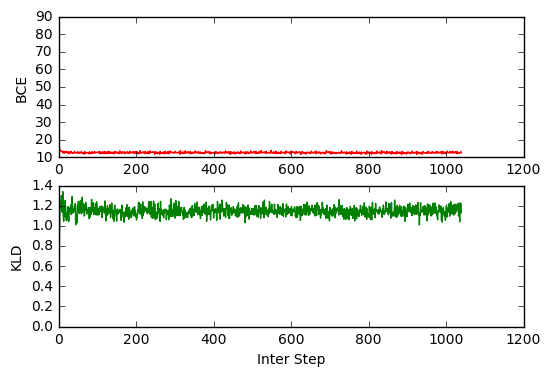

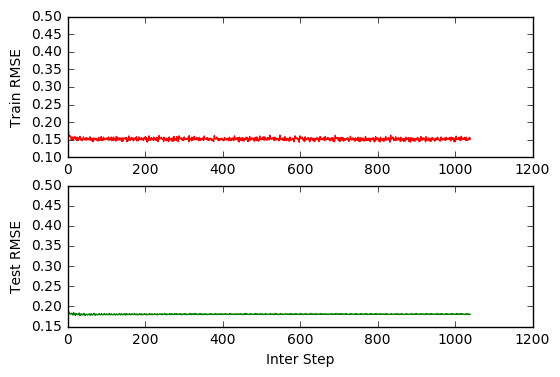


Performance measures. Training data
RMSE Total=  0.15278131655380162
Accuracy flags =  0.8271058083875116
Accuracy protocol =  0.815166742079652
Accuracy service =  0.4631548030133441
RMSE Continous Vars =  0.2091571002771479

Performance measures. Test data
RMSE Total =  0.18095170465727978
Accuracy flags =  0.6582239176721079
Accuracy protocol =  0.837473385379702
Accuracy service =  0.4445085166784954
RMSE Continous Vars =  0.26513857724142564


In [14]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

# change as you change the input and output data
xtraining = YTrainAN5MOhe
xtesting =  YTestAN5MOhe
ytraining = XTrainM
ytesting =  XTestM



#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]

#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

k = 1  # dropout probability
cnn = config_nn_2(num_hidden_vars, f_activation, k)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
log_px_given_z = -tf.reduce_sum(
    y * tf.log(cnn['yhat'] + 1e-10) +
    (1 - y) * tf.log(1 - cnn['yhat'] + 1e-10), 1)

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)

KLD = tf.reduce_mean(kl_div)
BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

loss = KLD + BCE 


learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 80
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        feed_dict = {cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce, yhat, _ = sess.run([loss, KLD, BCE, cnn['yhat'], train_step], feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE: {1:.6f}| Train rmse: {2:.6f}| Test rmse: {3:.6f}".format(kld,
                                                                                           bce,
                                                                                           batch_rmse,
                                                                                           test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce'].append(bce)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(2, 1, 1)
plt.plot(history['bce'],'r-')
plt.ylabel('BCE')
plt.subplot(2, 1, 2)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

XTestM_hat = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, K.learning_phase(): 0})
XTrainM_hat = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtraining, K.learning_phase(): 0})

print('\nPerformance measures. Training data')
print('RMSE Total=  {}'.format(sqrt(mean_squared_error(ytraining,XTrainM_hat ))))

print('Accuracy flags =  {}'.format(accuracy(XTrainM_hat[:,32:43], ytraining[:,32:43])))
print('Accuracy protocol =  {}'.format(accuracy(XTrainM_hat[:,43:46], ytraining[:,43:46])))
print('Accuracy service =  {}'.format(accuracy(XTrainM_hat[:,46:], ytraining[:,46:])))
print('RMSE Continous Vars =  {}'.format(sqrt(mean_squared_error(XTrainM_hat[:,:32], ytraining[:,:32]))))

print('\nPerformance measures. Test data')
print('RMSE Total =  {}'.format(sqrt(mean_squared_error(ytesting,XTestM_hat ))))

print('Accuracy flags =  {}'.format(accuracy(XTestM_hat[:,32:43], ytesting[:,32:43])))
print('Accuracy protocol =  {}'.format(accuracy(XTestM_hat[:,43:46], ytesting[:,43:46])))
print('Accuracy service =  {}'.format(accuracy(XTestM_hat[:,46:], ytesting[:,46:])))
print('RMSE Continous Vars =  {}'.format(sqrt(mean_squared_error(XTestM_hat[:,:32], ytesting[:,:32]))))

## 2.2 Generate new XTrain (synthetic data) with the autoencoder
#### We generate a list of synthetic datasets using the already trained autoencoder

In [15]:
xtrain_hat_list = []
xtrain_hat_ohe_list = []
for i in range(2):
    xtrain_hat = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtraining, K.learning_phase(): 0})
    xtrain_hat_list.append(xtrain_hat)
    t = np.copy(xtrain_hat)
    t[:,32:43] = labelOHEncodedFromPrediction(t[:,32:43])
    t[:,43:46] = labelOHEncodedFromPrediction(t[:,43:46])
    t[:,46:] = labelOHEncodedFromPrediction(t[:,46:])
    xtrain_hat_ohe_list.append(t)
    

In [16]:
zm = cnn['z_mu'].eval(feed_dict={cnn['x_ini']: xtraining, K.learning_phase(): 0})
zls = cnn['z_log_sigma'].eval(feed_dict={cnn['x_ini']: xtraining, K.learning_phase(): 0})

## 2.3 Analysis on synthetic datasets
### 2.3.1 Initial analysis

#### We perform an small analysis on the latent variables (mean and std) and the synthetic data. The intention is to be sure that the synthetic data is not constant, meaning that different synthetic datasets have differences and we are not generating always the same data, and at the same time the values means are close enough.

In [17]:
print(np.mean(np.abs(xtrain_hat_list[1]-XTrainM)))
print(np.mean(np.abs(xtrain_hat_ohe_list[1]-XTrainM)))

0.051643052383
0.0445361148981


In [18]:
xrandom_hat_list = []
xrandom_hat_ohe_list = []
increase_std = 2
for i in range(2):
    zval = zm + np.exp(zls)*np.random.randn(zls.shape[0],zls.shape[1])*increase_std
    xrandom_hat = cnn['yhat'].eval(feed_dict={cnn['z']: zval, K.learning_phase(): 0})
    xrandom_hat_list.append(xrandom_hat)
    tt = np.copy(xrandom_hat)
    tt[:,32:43] = labelOHEncodedFromPrediction(tt[:,32:43])
    tt[:,43:46] = labelOHEncodedFromPrediction(tt[:,43:46])
    tt[:,46:] = labelOHEncodedFromPrediction(tt[:,46:])
    xrandom_hat_ohe_list.append(tt)
    

In [19]:
np.mean(xrandom_hat_ohe_list[0]-xrandom_hat_ohe_list[1], axis=0)

array([ -7.48254388e-05,  -5.81187778e-04,  -7.00181874e-04,
         4.33889763e-05,  -1.57242939e-05,  -1.95594453e-06,
        -1.71883591e-03,  -2.05612105e-06,  -7.90012109e-06,
        -7.32883609e-06,  -2.16007311e-06,  -3.20976210e-06,
        -5.31039332e-05,   9.95648676e-04,   9.36386423e-05,
         1.55747379e-03,   1.56454695e-03,   3.19328334e-04,
         3.15794226e-04,  -1.64668635e-03,   1.05342027e-04,
        -2.17938621e-04,   3.38737271e-04,  -9.80665558e-04,
        -1.55621953e-03,   1.39636948e-04,   2.63385118e-05,
        -1.77223355e-05,   1.55421672e-03,   1.56524312e-03,
         3.19051032e-04,   3.10991687e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.63527101e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -1.63527101e-03,
         0.00000000e+00,  -1.58764178e-05,   1.58764178e-05,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [20]:
np.mean(xtrain_hat_ohe_list[0]-xtrain_hat_ohe_list[1], axis=0)

array([ -2.74839858e-05,   4.52527092e-05,   6.33548916e-05,
         1.67329858e-06,   9.11336883e-07,   3.41608768e-08,
         1.64525758e-04,   3.74748652e-07,   3.15696155e-07,
         2.30327601e-07,   5.91842522e-08,   1.52542142e-07,
         2.84200519e-06,   2.57841966e-05,   2.34064228e-05,
         3.41576451e-05,   3.97446274e-05,  -1.12527909e-04,
        -1.16712610e-04,   3.75408745e-05,  -6.76857017e-05,
        -7.21105389e-05,   6.21911386e-05,   1.11936111e-04,
         8.16402244e-05,  -1.11251626e-04,  -1.71861000e-04,
        -5.92416181e-05,   3.66404129e-05,   3.56655037e-05,
        -9.52165719e-05,  -1.19290329e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   3.17528356e-05,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -3.17528356e-05,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [21]:
np.std(xtrain_hat_ohe_list[0]-xtrain_hat_ohe_list[1], axis=0)

array([  9.89768282e-03,   2.43987516e-02,   3.15710679e-02,
         1.71077880e-03,   5.66115137e-04,   5.93639925e-05,
         8.43589306e-02,   1.84381774e-04,   2.97066697e-04,
         2.30506354e-04,   6.16537000e-05,   1.09799053e-04,
         2.08456093e-03,   4.16183174e-02,   1.32969636e-02,
         6.45382479e-02,   6.47387207e-02,   4.89499792e-02,
         5.01574390e-02,   6.11120239e-02,   2.84789149e-02,
         3.21123302e-02,   2.97074635e-02,   5.38461730e-02,
         5.92231825e-02,   4.72071171e-02,   7.53985420e-02,
         2.38016285e-02,   6.42979667e-02,   6.48720711e-02,
         4.18482162e-02,   4.96873744e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.10995993e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.10995993e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [22]:
np.mean(xrandom_hat_ohe_list[1][:,32:], axis = 0)

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   3.66515040e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.33484960e-01,   0.00000000e+00,   1.66702390e-04,
         9.99833286e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.55674633e-05,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   4.96344447e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [23]:
np.mean(xtrain_hat_ohe_list[1][:,32:], axis = 0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.36745968,  0.        ,  0.        ,  0.        ,  0.63254029,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.53515434,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.46484563,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

## 2.4  Prediction results using real and synthetic data for both training and testing 
## NO Data Augmentation
#### Here the intention is to check that using the real or synthetic data either at training or test times does not change results. That is, to check if new synthetic XTrain have the same behaviour as the original

### 2.4.1. - Using prediction algorithm: Logistic Regression

In [24]:
# multinomial logistic regression
xtrain = XTrainM
xtest = xtrain_hat_ohe_list[1]

clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Real')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

clf.fit(xtest, YTrainAN5)

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Train')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))


Training data.2-fold CV. Train w/Real --> Predict w/Fake
Accuracy =  0.9783525041080231

Training data.2-fold CV. Train w/Real --> Predict w/Real
Accuracy =  0.9931731402760909

Training data.2-fold CV. Train w/Fake --> Predict w/Train
Accuracy =  0.8221206131472617

Training data.2-fold CV. Train w/Fake --> Predict w/Fake
Accuracy =  0.9808609781461107


### 2.4.2. - Using prediction algorithm: Random Forest

In [25]:
# random forest
from sklearn.ensemble import RandomForestClassifier
xtrain = XTrainM
xtest = xtrain_hat_ohe_list[1]

clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Real')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

clf.fit(xtest, YTrainAN5)

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Train')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))


Training data.2-fold CV. Train w/Real --> Predict w/Fake
Accuracy =  0.9807815960562978

Training data.2-fold CV. Train w/Real --> Predict w/Real
Accuracy =  0.9998571122383367

Training data.2-fold CV. Train w/Fake --> Predict w/Train
Accuracy =  0.8358695911028554

Training data.2-fold CV. Train w/Fake --> Predict w/Fake
Accuracy =  0.9228088558659395


## 2.5  Prediction results using real and synthetic data for  training 
## WITH Data Augmentation (1 x Original + 1 x Synthetic)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus an instance of synthetic data  of same size as original data. Having finally 2x the number of samples that we had originally in the real data.

In [26]:
# random forest
from sklearn.ensemble import RandomForestClassifier
xtrain1 = XTrainM
xtest = XTestM

xtrain2 = np.append(XTrainM, xtrain_hat_ohe_list[1], axis=0)
YTrain2 = np.append(YTrainAN5, YTrainAN5, axis=0)

### 2.5.1. - Using prediction algorithm: Random Forest

In [27]:
# random forest
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7303938963804116

Prediction with augmented data for training
Accuracy =  0.7317689850958127


### 2.5.2. - Using prediction algorithm: Logistic Regression

In [28]:
# multinomial logistic regression

clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.73624911284599

Prediction with augmented data for training
Accuracy =  0.7660574875798438


### 2.5.3. - Using prediction algorithm: Linear SVM

In [29]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.738777501774308

Prediction with augmented data for training
Accuracy =  0.7293293115684882


### 2.5.4. - Using prediction algorithm: MLP

In [30]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7752395315826828

Prediction with augmented data for training
Accuracy =  0.7830908445706175


## 2.6  Prediction results using real and synthetic data for  training 
## WITH Data Augmentation (1 x Original + 1 x Synthetic-label-balanced)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus one instance of synthetic data of a different size and label distribution of the original data. We try to compensate in this way the label unbalanced of the original data.

In [31]:
labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*21000).flatten(),
                             np.array(['PROBE']*55000).flatten()),
                             np.array(['R2L']*66000).flatten()
                            ),np.array(['U2R']*67000).flatten())

xtraining_new = lb5.transform(labels_to_generate)

#labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*20).flatten(),
#                             np.array(['PROBE']*20).flatten()),
#                             np.array(['R2L']*20).flatten()
#                            ),np.array(['U2R']*20).flatten())
#
#xtraining_new = lb5.transform(labels_to_generate)

xtrain_new = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtraining_new, K.learning_phase(): 0})

xtrain_new[:,32:43] = labelOHEncodedFromPrediction(xtrain_new[:,32:43])

xtrain_new[:,43:46] = labelOHEncodedFromPrediction(xtrain_new[:,43:46])

xtrain_new[:,46:] = labelOHEncodedFromPrediction(xtrain_new[:,46:])

xtrain3 = np.append(XTrainM, xtrain_new, axis=0)
YTrain3 = np.append(YTrainAN5,labels_to_generate)

### 2.6.1 - Using prediction algorithm: MLP

In [32]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7775461320085166


### 2.6.2 - Using prediction algorithm: Linear SVM

In [33]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7413502484031228


### 2.6.3 - Using prediction algorithm: Random Forest

In [34]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.731902058197303


# 3. Model B of the paper

## 3.1 Train the model

Epoch 0 |Step 0 | Loss: 60.250957| KLD: 0.030022507533431053| BCE_c: 2.419333| BCE_flg: 7.600878| BCE_prot: 2.110423| BCE_srv: 48.090302| Train rmse: 0.297044| Test rmse: 0.328280
Epoch 0 |Step 50 | Loss: 8.118063| KLD: 0.015150905586779118| BCE_c: 1.615678| BCE_flg: 1.613373| BCE_prot: 1.274574| BCE_srv: 3.599287| Train rmse: 4.849307| Test rmse: 4.909283
Epoch 0 |Step 100 | Loss: 8.467844| KLD: 0.03867267444729805| BCE_c: 1.621015| BCE_flg: 1.767179| BCE_prot: 1.190564| BCE_srv: 3.850414| Train rmse: 5.296710| Test rmse: 5.247768
Epoch 0 |Step 150 | Loss: 8.033318| KLD: 0.160263329744339| BCE_c: 1.547375| BCE_flg: 1.643325| BCE_prot: 1.048458| BCE_srv: 3.633896| Train rmse: 5.176176| Test rmse: 5.230762
Epoch 0 |Step 200 | Loss: 8.216261| KLD: 0.5216051340103149| BCE_c: 1.459371| BCE_flg: 1.572572| BCE_prot: 1.069013| BCE_srv: 3.593699| Train rmse: 5.362696| Test rmse: 5.374787
Epoch 0 |Step 250 | Loss: 7.827271| KLD: 0.5812792778015137| BCE_c: 1.404201| BCE_flg: 1.223601| BCE_prot: 

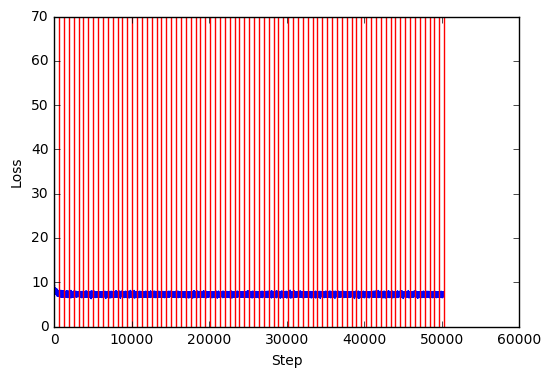

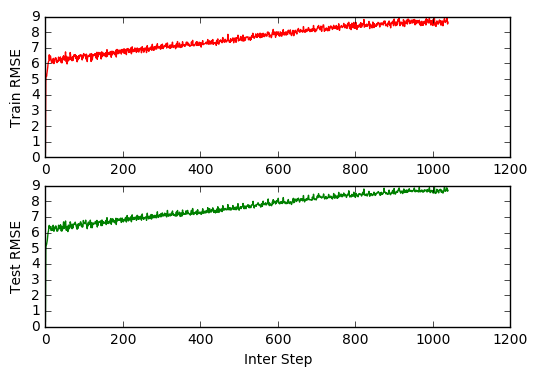


Performance measures. Training data
RMSE Total=  8.769829570402067
Accuracy flags =  0.8145554999880927
Accuracy protocol =  0.815166742079652
Accuracy service =  0.44973129162598335
RMSE Continous Vars =  0.21574502804121837

Performance measures. Test data
RMSE Total =  8.746655849367444
Accuracy flags =  0.6527679205110007
Accuracy protocol =  0.837473385379702
Accuracy service =  0.4331973030518098
RMSE Continous Vars =  0.2656427020359976


In [13]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

# change as you change the input and output data
xtraining = YTrainAN5MOhe
xtesting =  YTestAN5MOhe
ytraining = XTrainM
ytesting =  XTestM

#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]
output_dim_c = 32
output_dim_d_flg = 11
output_dim_d_prot = 3
output_dim_d_srv = 70

#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

k = 1  # dropout probability
cnn = config_nn_2a(num_hidden_vars, f_activation, k)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
def f_log_px_given_z(yhat, y):
    return (-tf.reduce_sum(
    y * tf.log(yhat + 1e-10) +
    (1 - y) * tf.log(1 - yhat + 1e-10), 1))

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)


yhat_c = tf.slice(cnn['yhat'],[0,0],[-1,output_dim_c])
yhat_d_flg = tf.slice(cnn['yhat'],[0,output_dim_c],[-1,output_dim_d_flg])
yhat_d_prot = tf.slice(cnn['yhat'],[0,output_dim_c+output_dim_d_flg],[-1,output_dim_d_prot])
yhat_d_srv = tf.slice(cnn['yhat'],[0,output_dim_c+output_dim_d_flg+output_dim_d_prot],[-1,output_dim_d_srv])

y_c = tf.slice(y,[0,0],[-1,output_dim_c])
y_d_flg = tf.slice(y,[0,output_dim_c],[-1,output_dim_d_flg])
y_d_prot = tf.slice(y,[0,output_dim_c+output_dim_d_flg],[-1,output_dim_d_prot])
y_d_srv = tf.slice(y,[0,output_dim_c+output_dim_d_flg+output_dim_d_prot],[-1,output_dim_d_srv])

#BCE_rms = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(cnn['yhat'], y)),1)))
#BCE_rms = tf_rmse(cnn['yhat'],y)

from keras.layers import Activation
#yhat_c = Activation('sigmoid')(yhat_c)
#BCE_rms_c = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(yhat_c, y_c)),1)))
#BCE_rms_c = tf.nn.l2_loss(yhat_c-y_c)
BCE_rms_c = tf_rmse(yhat_c,y_c)
yhat_d_flg = Activation('sigmoid')(yhat_d_flg)
BCE_xen_d_flg = tf.reduce_mean(f_log_px_given_z(yhat_d_flg, y_d_flg)) 
yhat_d_prot = Activation('sigmoid')(yhat_d_prot)
BCE_xen_d_prot = tf.reduce_mean(f_log_px_given_z(yhat_d_prot, y_d_prot))
yhat_d_srv = Activation('sigmoid')(yhat_d_srv)
BCE_xen_d_srv = tf.reduce_mean(f_log_px_given_z(yhat_d_srv, y_d_srv)) 


KLD = tf.reduce_mean(kl_div)
#BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

#loss = KLD + BCE 
loss_2 = KLD + BCE_rms_c + BCE_xen_d_flg + BCE_xen_d_prot + BCE_xen_d_srv 


learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_2)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 80
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce_c':[], 'bce_flg':[], 'bce_prot':[], 'bce_srv':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        feed_dict = {cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce_c, bce_flg, bce_prot, bce_srv, yhat, _ = sess.run(
                                                [loss_2, KLD, 
                                                 BCE_rms_c, BCE_xen_d_flg, BCE_xen_d_prot, BCE_xen_d_srv,
                                                 cnn['yhat'], train_step], 
                                                 feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE_c: {1:.6f}| BCE_flg: {2:.6f}| BCE_prot: {3:.6f}| ".format(kld, bce_c, bce_flg, bce_prot), 
                                                                                           end="")
            print("BCE_srv: {0:.6f}| Train rmse: {1:.6f}| Test rmse: {2:.6f}".format(bce_srv,
                                                                                       batch_rmse,
                                                                                       test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce_c'].append(bce_c)
            history['bce_flg'].append(bce_flg)
            history['bce_prot'].append(bce_prot)
            history['bce_srv'].append(bce_srv)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(5, 1, 1)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.subplot(5, 1, 2)
plt.plot(history['bce_c'],'r-')
plt.ylabel('BCE_c')
plt.subplot(5, 1, 3)
plt.plot(history['bce_flg'],'r-')
plt.ylabel('BCE_flg')
plt.subplot(5, 1, 4)
plt.plot(history['bce_prot'],'r-')
plt.ylabel('BCE_prot')
plt.subplot(5, 1, 5)
plt.plot(history['bce_srv'],'r-')
plt.ylabel('BCE_srv')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

XTestM_hat = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, K.learning_phase(): 0})
XTrainM_hat = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtraining, K.learning_phase(): 0})

print('\nPerformance measures. Training data')
print('RMSE Total=  {}'.format(sqrt(mean_squared_error(ytraining,XTrainM_hat ))))

print('Accuracy flags =  {}'.format(accuracy(XTrainM_hat[:,32:43], ytraining[:,32:43])))
print('Accuracy protocol =  {}'.format(accuracy(XTrainM_hat[:,43:46], ytraining[:,43:46])))
print('Accuracy service =  {}'.format(accuracy(XTrainM_hat[:,46:], ytraining[:,46:])))
print('RMSE Continous Vars =  {}'.format(sqrt(mean_squared_error(XTrainM_hat[:,:32], ytraining[:,:32]))))

print('\nPerformance measures. Test data')
print('RMSE Total =  {}'.format(sqrt(mean_squared_error(ytesting,XTestM_hat ))))

print('Accuracy flags =  {}'.format(accuracy(XTestM_hat[:,32:43], ytesting[:,32:43])))
print('Accuracy protocol =  {}'.format(accuracy(XTestM_hat[:,43:46], ytesting[:,43:46])))
print('Accuracy service =  {}'.format(accuracy(XTestM_hat[:,46:], ytesting[:,46:])))
print('RMSE Continous Vars =  {}'.format(sqrt(mean_squared_error(XTestM_hat[:,:32], ytesting[:,:32]))))

## 3.2 Generate new XTrain (synthetic data) with the autoencoder
#### We generate a list of synthetic datasets using the already trained autoencoder

In [14]:
xtrain_hat_list = []
xtrain_hat_ohe_list = []
for i in range(2):
    xtrain_hat = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtraining, K.learning_phase(): 0})
    xtrain_hat_list.append(xtrain_hat)
    t = np.copy(xtrain_hat)
    t[:,32:43] = labelOHEncodedFromPrediction(t[:,32:43])
    t[:,43:46] = labelOHEncodedFromPrediction(t[:,43:46])
    t[:,46:] = labelOHEncodedFromPrediction(t[:,46:])
    xtrain_hat_ohe_list.append(t)
    

In [15]:
zm = cnn['z_mu'].eval(feed_dict={cnn['x_ini']: xtraining, K.learning_phase(): 0})
zls = cnn['z_log_sigma'].eval(feed_dict={cnn['x_ini']: xtraining, K.learning_phase(): 0})

## 3.3 Analysis on synthetic datasets
### 3.3.1 Initial analysis

#### We perform an small analysis on the latent variables (mean and std) and the synthetic data. The intention is to be sure that the synthetic data is not constant, meaning that different synthetic datasets have differences and we are not generating always the same data, and at the same time the values means are close enough.

In [16]:
print(np.mean(np.abs(xtrain_hat_list[1]-XTrainM)))
print(np.mean(np.abs(xtrain_hat_ohe_list[1]-XTrainM)))

6.28782914348
0.0468068949628


In [17]:
xrandom_hat_list = []
xrandom_hat_ohe_list = []
increase_std = 2
for i in range(2):
    zval = zm + np.exp(zls)*np.random.randn(zls.shape[0],zls.shape[1])*increase_std
    xrandom_hat = cnn['yhat'].eval(feed_dict={cnn['z']: zval, K.learning_phase(): 0})
    xrandom_hat_list.append(xrandom_hat)
    tt = np.copy(xrandom_hat)
    tt[:,32:43] = labelOHEncodedFromPrediction(tt[:,32:43])
    tt[:,43:46] = labelOHEncodedFromPrediction(tt[:,43:46])
    tt[:,46:] = labelOHEncodedFromPrediction(tt[:,46:])
    xrandom_hat_ohe_list.append(tt)
    

In [18]:
np.mean(xrandom_hat_ohe_list[0]-xrandom_hat_ohe_list[1], axis=0)

array([  1.28635598e-04,   1.84460645e-04,   2.17921392e-04,
        -2.67901432e-05,   1.74408997e-05,  -1.84557862e-07,
         6.47641544e-04,   3.80276033e-05,   1.23029322e-05,
         1.48724048e-05,   8.31191392e-06,  -1.46986522e-05,
         1.71449828e-05,  -5.70979144e-04,  -6.74493349e-05,
        -8.18399596e-04,  -8.52897007e-04,   1.60194236e-06,
         7.10443055e-05,   8.81465618e-04,   8.53386664e-05,
         2.65121809e-04,  -2.02946190e-04,   3.11326789e-04,
         6.82249782e-04,   9.97382085e-05,   3.29920062e-04,
         1.21396624e-04,  -8.15460808e-04,  -7.75983266e-04,
         1.19190372e-05,  -1.04575502e-05,   0.00000000e+00,
        -7.93820891e-06,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -1.11134921e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.11928745e-03,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [19]:
np.mean(xtrain_hat_ohe_list[0]-xtrain_hat_ohe_list[1], axis=0)

array([  2.33657975e-05,  -3.43781758e-05,  -6.10922070e-05,
        -5.43766589e-07,   3.00178522e-06,   4.68373116e-07,
        -1.66155209e-04,   3.67015627e-06,  -2.41184375e-06,
         3.21784592e-06,  -2.59676938e-07,   5.83122585e-07,
         5.43884835e-06,  -6.60838532e-06,  -1.98864236e-05,
         1.85911603e-07,  -4.67377276e-06,   9.79207325e-05,
         1.04526269e-04,  -3.70576199e-05,   4.84016091e-05,
         7.18017618e-05,  -2.64199662e-05,  -1.26394239e-04,
        -1.12699694e-04,   9.89327891e-05,   1.47591520e-04,
         4.45693404e-05,   7.85225097e-07,   5.91467187e-06,
         7.80444243e-05,   8.55368271e-05,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.38146269e-04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -2.38146269e-04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [20]:
np.std(xtrain_hat_ohe_list[0]-xtrain_hat_ohe_list[1], axis=0)

array([ 0.0187892 ,  0.04473099,  0.05895035,  0.00431823,  0.00183411,
        0.0005716 ,  0.15866266,  0.0013405 ,  0.00119842,  0.00140567,
        0.00083754,  0.00111171,  0.00482491,  0.08161046,  0.0210496 ,
        0.1268748 ,  0.12704703,  0.07301556,  0.07621857,  0.13051987,
        0.04102164,  0.05461185,  0.04869631,  0.10112269,  0.12625003,
        0.07299308,  0.12539932,  0.03697291,  0.12573978,  0.12578414,
        0.06253997,  0.07546002,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.21117941,  0.        ,  0.        ,
        0.        ,  0.21117941,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [21]:
np.mean(xrandom_hat_ohe_list[1][:,32:], axis = 0)

array([  0.00000000e+00,   7.93820891e-06,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   3.72540146e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.27451897e-01,   0.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   4.91414815e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [22]:
np.mean(xtrain_hat_ohe_list[1][:,32:], axis = 0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.35839427,  0.        ,  0.        ,  0.        ,  0.64160573,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.52107197,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.47892803,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

## 3.4  Prediction results using real and synthetic data for both training and testing 
## NO Data Augmentation
#### Here the intention is to check that using the real or synthetic data either at training or test times does not change results. That is, to check if new synthetic XTrain have the same behaviour as the original

### 3.4.1. - Using prediction algorithm: Logistic Regression

In [23]:
# multinomial logistic regression
xtrain = XTrainM
xtest = xtrain_hat_ohe_list[1]

clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Real')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

clf.fit(xtest, YTrainAN5)

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Train')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))


Training data.2-fold CV. Train w/Real --> Predict w/Fake
Accuracy =  0.9399950783104316

Training data.2-fold CV. Train w/Real --> Predict w/Real
Accuracy =  0.9931731402760909

Training data.2-fold CV. Train w/Fake --> Predict w/Train
Accuracy =  0.6993085819977297

Training data.2-fold CV. Train w/Fake --> Predict w/Fake
Accuracy =  0.9393520833829472


### 3.4.2. - Using prediction algorithm: Random Forest

In [24]:
# random forest
from sklearn.ensemble import RandomForestClassifier
xtrain = XTrainM
xtest = xtrain_hat_ohe_list[1]

clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Real --> Predict w/Real')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

clf.fit(xtest, YTrainAN5)

y_hat = clf.predict(xtrain)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Train')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))

y_hat = clf.predict(xtest)
print('\nTraining data.2-fold CV. Train w/Fake --> Predict w/Fake')
print('Accuracy =  {}'.format(accuracy_score(YTrainAN5, y_hat)))


Training data.2-fold CV. Train w/Real --> Predict w/Fake
Accuracy =  0.9302231430544641

Training data.2-fold CV. Train w/Real --> Predict w/Real
Accuracy =  0.9998571122383367

Training data.2-fold CV. Train w/Fake --> Predict w/Train
Accuracy =  0.8609860843196558

Training data.2-fold CV. Train w/Fake --> Predict w/Fake
Accuracy =  0.9797337524707675


## 3.5  Prediction results using real and synthetic data for  training 
## WITH Data Augmentation (1 x Original + 1 x Synthetic)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus an instance of synthetic data  of same size as original data. Having finally 2x the number of samples that we had originally in the real data.

In [25]:
# random forest
from sklearn.ensemble import RandomForestClassifier
xtrain1 = XTrainM
xtest = XTestM

xtrain2 = np.append(XTrainM, xtrain_hat_ohe_list[1], axis=0)
YTrain2 = np.append(YTrainAN5, YTrainAN5, axis=0)

### 3.5.1. - Using prediction algorithm: Random Forest

In [26]:
# random forest
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7303938963804116

Prediction with augmented data for training
Accuracy =  0.7317689850958127


### 3.5.2. - Using prediction algorithm: Logistic Regression

In [27]:
# multinomial logistic regression

clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.73624911284599

Prediction with augmented data for training
Accuracy =  0.7582505322924059


### 3.5.3. - Using prediction algorithm: Linear SVM

In [28]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.738777501774308

Prediction with augmented data for training
Accuracy =  0.7413946061036196


### 3.5.4. - Using prediction algorithm: MLP

In [29]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7752395315826828

Prediction with augmented data for training
Accuracy =  0.7830021291696239


## 3.6  Prediction results using real and synthetic data for  training 
## WITH Data Augmentation (1 x Original + 1 x Synthetic-label-balanced)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus one instance of synthetic data of a different size and label distribution of the original data. We try to compensate in this way the label unbalanced of the original data.

In [30]:
labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*21000).flatten(),
                             np.array(['PROBE']*55000).flatten()),
                             np.array(['R2L']*66000).flatten()
                            ),np.array(['U2R']*67000).flatten())

xtraining_new = lb5.transform(labels_to_generate)

#labels_to_generate=np.append(np.append(np.append(np.array(['DOS']*20).flatten(),
#                             np.array(['PROBE']*20).flatten()),
#                             np.array(['R2L']*20).flatten()
#                            ),np.array(['U2R']*20).flatten())
#
#xtraining_new = lb5.transform(labels_to_generate)

xtrain_new = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtraining_new, K.learning_phase(): 0})

xtrain_new[:,32:43] = labelOHEncodedFromPrediction(xtrain_new[:,32:43])

xtrain_new[:,43:46] = labelOHEncodedFromPrediction(xtrain_new[:,43:46])

xtrain_new[:,46:] = labelOHEncodedFromPrediction(xtrain_new[:,46:])

xtrain3 = np.append(XTrainM, xtrain_new, axis=0)
YTrain3 = np.append(YTrainAN5,labels_to_generate)

### 3.6.1. - Using prediction algorithm: MLP

In [31]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7721344925479063


### 3.6.2. - Using prediction algorithm: Linear SVM

In [32]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7357168204400284


### 3.6.3. - Using prediction algorithm: Logistic Regression

In [79]:
# logistic regression
from sklearn.linear_model import LogisticRegression   


clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7530163236337828


### 3.6.4. - Using prediction algorithm: Random Forest

In [33]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain3, YTrain3)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with augmented data for training
Accuracy =  0.7338094393186657


## 3.7  Prediction results using real and synthetic data for  training 
## WITH Data Augmentation (1 x Original + 2 x Synthetic)
#### Check prediction improvement when increasing training data with additional synthetic data. We use as training data the original real data plus two instances of synthetic data of same size as original data. Having finally 3x the number of samples that we had originally in the real data.

In [34]:
# random forest
from sklearn.ensemble import RandomForestClassifier
xtrain1 = XTrainM
xtest = XTestM

xtrain2 = np.append(np.append(XTrainM, xtrain_hat_ohe_list[1], axis=0),xtrain_hat_ohe_list[0], axis=0)
YTrain2 = np.append(np.append(YTrainAN5, YTrainAN5, axis=0),YTrainAN5, axis=0)

### 3.7.1. - Using prediction algorithm: Random Forest

In [35]:
# random forest
clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7303938963804116

Prediction with augmented data for training
Accuracy =  0.7330110007097232


### 3.7.2. - Using prediction algorithm: Logistic Regression

In [36]:
# multinomial logistic regression

clf = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.73624911284599

Prediction with augmented data for training
Accuracy =  0.7591820440028388


### 3.7.3. - Using prediction algorithm: Linear SVM

In [37]:
# linear SVC
from sklearn.svm import LinearSVC   


clf = LinearSVC(C=1000, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.738777501774308

Prediction with augmented data for training
Accuracy =  0.7417938254080908


### 3.7.4 - Using prediction algorithm: MLP

In [38]:
# MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(200, 50), random_state=1)

clf.fit(xtrain1, YTrainAN5)

y_hat = clf.predict(xtest)
print('\nPrediction with original data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


clf.fit(xtrain2, YTrain2)

y_hat = clf.predict(xtest)
print('\nPrediction with augmented data for training')
print('Accuracy =  {}'.format(accuracy_score(YTestAN5, y_hat)))


Prediction with original data for training
Accuracy =  0.7752395315826828

Prediction with augmented data for training
Accuracy =  0.7949787083037615


In [48]:
sess.close()